In [1]:
%matplotlib inline
from matplotlib import pylab as plt
plt.style.use('ggplot')

from idrf import IDRF #Deconvolution routine

In [2]:
from obspy.clients.fdsn.client import Client

client = Client('IRIS')

network = 'IU'
station = 'RSSD'

inv = client.get_stations(network=network, station=station,level='response')

sta = inv[0][0]
sta

Station RSSD (Black Hills, South Dakota, USA)
	Station Code: RSSD
	Channel Count: 72/72 (Selected/Total)
	1999-09-24T00:00:00.000000Z - 2009-09-08T20:00:00.000000Z
	Access: open 
	Latitude: 44.12, Longitude: -104.04, Elevation: 2090.0 m
	Available Channels:
		RSSD..BC0, RSSD..BC1, RSSD.00.BHZ (3x), RSSD.00.BH1 (4x), 
		RSSD.00.BH2 (4x), RSSD.00.LHZ (3x), RSSD.00.LH1 (4x), 
		RSSD.00.LH2 (4x), RSSD.00.UHZ (2x), RSSD.00.UH1 (3x), 
		RSSD.00.UH2 (3x), RSSD.00.VE1, RSSD.00.VHZ (3x), RSSD.00.VH1 (4x), 
		RSSD.00.VH2 (4x), RSSD.00.VK1, RSSD.10.BHZ, RSSD.10.BHN, RSSD.10.BHE
		RSSD.10.HHZ, RSSD.10.HHN, RSSD.10.HHE, RSSD.10.LHZ, RSSD.10.LHN, 
		RSSD.10.LHE, RSSD.20.HLZ, RSSD.20.HLN, RSSD.20.HLE, RSSD.20.HNZ (2x)
		RSSD.20.HNN (2x), RSSD.20.HNE (2x), RSSD.20.LLZ, RSSD.20.LLN, 
		RSSD.20.LLE, RSSD.20.LNZ (2x), RSSD.20.LNN (2x), RSSD.20.LNE (2x)

In [3]:
import wget

!rm *.ndk

years = range(6,18)
months  = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
for year in years:
    for month in months:
        url='http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/20%02d/%s%02d.ndk' % (year, month, year)
        print(url)
        wget.download( url )

http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/jan06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/feb06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/mar06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/apr06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/may06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/jun06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/jul06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/aug06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/sep06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/oct06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/nov06.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2006/dec06.ndk
http

http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/apr14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/may14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/jun14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/jul14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/aug14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/sep14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/oct14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/nov14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2014/dec14.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2015/jan15.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2015/feb15.ndk
http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/2015/mar15.ndk
http

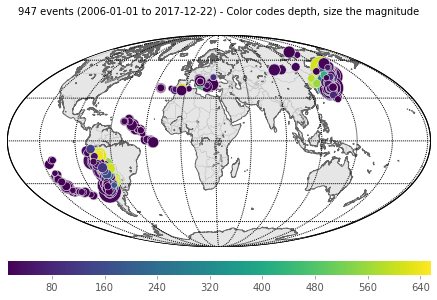

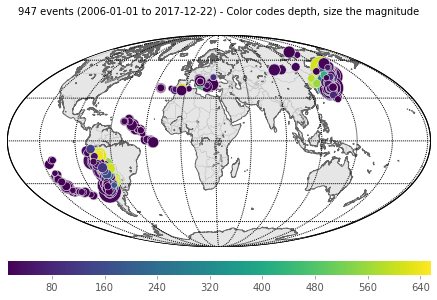

In [4]:
import obspy
from obspy.geodetics.base import gps2dist_azimuth
from obspy.clients.syngine import Client
from obspy.taup import TauPyModel

cat = obspy.core.event.Catalog()

for year in years:
    for month in months:
        tmp = obspy.read_events('%s%02d.ndk' % (month, year))
        cat = cat + tmp.filter('magnitude >= 5.5')
    
    
cat2 = obspy.core.event.Catalog()

for evt in cat:
    elat=evt.origins[0].latitude
    elon=evt.origins[0].longitude
    slat=sta.latitude
    slon=sta.longitude
    delm, az, baz = gps2dist_azimuth(elat, elon, slat, slon)
    deldeg=delm/1000/111.11
    if deldeg > 55 and deldeg < 85:
        cat2.append(evt)
        
cat2.plot()
    

In [7]:
from scipy.signal import tukey
from numpy import arange, linspace, zeros
from numpy.random import randn
from numpy import argmax, nan
import warnings
warnings.filterwarnings('ignore')

model = TauPyModel(model="iasp91")

#tries = linspace(0.5, 0.90, 5)
pctage=0.80

#tshifts = [-6, -3, 0, 3, 6]
tshifts = [0]

rbin    = zeros(len(tshifts)*len(cat2)*700).reshape(len(tshifts),len(cat2),700) * nan
rbin_s  = rbin.copy()
mbin1   = zeros(len(tshifts)*len(cat2)).reshape(len(tshifts),len(cat2)) * nan
mbin1_s = mbin1.copy()
mbin2   = mbin1.copy()
mbin2_s = mbin1.copy()

for ievt in range(len(cat2)):
    print('Working on %5d of %5d' % (ievt+1,len(cat2)))

    strike=cat2[ievt].focal_mechanisms[0].nodal_planes.nodal_plane_1.strike
    dip=cat2[ievt].focal_mechanisms[0].nodal_planes.nodal_plane_1.dip
    rake=cat2[ievt].focal_mechanisms[0].nodal_planes.nodal_plane_1.rake

    quake_depth_in_km=cat2[ievt].preferred_origin().depth/1000.0
    
    etime = cat2[ievt].preferred_origin().time

    slat=sta.latitude
    slon=sta.longitude
    elat=cat2[ievt].preferred_origin().latitude
    elon=cat2[ievt].preferred_origin().longitude

    client_syn = Client()
    
    t1=etime
    t2=etime+3600./2.

    for wvfrm_type in ['data','synthetic']:
    
        if wvfrm_type == 'synthetic':
            tmpstr = '%8.1f %8.1f %6.1f %8.1f %8.1f %8.2f %8.2f %8.2f ' % (elat, elon, quake_depth_in_km, slat, slon, strike, dip, rake)
            print(tmpstr)
            stis = client_syn.get_waveforms(model="iasp91_2s",
                                              sourcelatitude=elat,
                                              sourcelongitude=elon,
                                              sourcedepthinmeters=1000.*quake_depth_in_km,
                                              receiverlatitude=slat, receiverlongitude=slon,
                                              sourcedoublecouple=[strike,dip,rake],
                                              origintime=etime,
                                              units='velocity', starttime=t1, endtime=t2)
        else:
            #
            try:
                stis=client.get_waveforms(network,station,'10','LH?',t1,t2,attach_response=True)
                pre_filt = (0.005, 0.01, 5.0, 10.0)
                stis.remove_response(output='VEL', pre_filt=pre_filt)
            except:
                print('  get_waveforms failed.')
                break


            #


        print(stis)

        #print('...strike, dip, rake, elat, elon, quake_depth_in_km = %3d %3d %3d %5d %5d %5d %5d' % (strike, dip, rake, elat, elon, slat, quake_depth_in_km))


        delm, az, baz = gps2dist_azimuth(elat, elon, slat, slon)
        deldeg=delm/1000/111.11

        arrivals = model.get_travel_times(source_depth_in_km=quake_depth_in_km, distance_in_degree=deldeg,phase_list=['S'])

        try:
            stis.rotate('->ZNE',inventory=inv)
            #stis.rotate('NE->RT', back_azimuth = baz)
            stis.rotate('ZNE->LQT', inclination=arrivals[0].incident_angle, back_azimuth = baz)
            stis.detrend()
        except ValueError as e:
            print('Error: %s' % e)
            break

        stis.filter('bandpass', freqmin = 1./100., freqmax = 1./8., zerophase=True)
        #stis.filter('highpass', freq=1./20., zerophase=True)
        stis.resample(5)
        stis.differentiate()

        t1=etime+arrivals[0].time - 50
        t2=etime+arrivals[0].time + 50

        for ii, tshift in enumerate(tshifts):

            
            stis2=stis.copy().trim(t1+tshift,t2+tshift)
            
            try:
                dt = stis2[0].stats.delta
            except IndexError as e:
                print(e)
                break
                
            assert 'L' in stis2[0].stats.channel
            assert 'Q' in stis2[1].stats.channel
            #assert 'T' in stis2[2].stats.channel
            
            

            P = stis2[1].copy().data
            D = stis2[0].copy().data

            #Indeces to mask out
            i1 = int(len(P) * (pctage)/2)
            i2 = int(len(P) - i1)
            
            N1=P.copy()[:i1]
            N2=D.copy()[:i1]

            P[:i1]=0.0
            P[i2:]=0.0
            P[i1:i2]= P[i1:i2] * tukey(len(P[i1:i2]))

            smax  = max(abs(P))
            nmax1 = max(abs(N1))
            nmax2 = max(abs(N2))
            #print(i1,i2,imax)
            
            TB = 1.5
            NT = 2

            Poverlap = 0.99
            win_len  = 100

            #times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=0.99, win_len=70)
            #times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)
            
            times, RF     = IDRF(P,D,dt)
            _,     RFnorm = IDRF(P,D,dt)
            
            #_, RFnorm = ETMTM(P,P,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)

            if wvfrm_type == 'synthetic':
                rbin_s[ii,ievt,:len(RF)] = RF / max(abs(RFnorm))
                mbin1_s[ii,ievt] = smax/nmax1
                mbin2_s[ii,ievt] = smax/nmax2
            else:
                rbin[ii,ievt,:len(RF)] = RF / max(abs(RFnorm))
                mbin1[ii,ievt] = smax/nmax1
                mbin2[ii,ievt] = smax/nmax2
        

Working on     1 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2006-01-01T07:12:07.610646Z - 2006-01-01T07:42:06.610646Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-01-01T07:12:07.610646Z - 2006-01-01T07:42:06.610646Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-01-01T07:12:07.610646Z - 2006-01-01T07:42:06.610646Z | 1.0 Hz, 1800 samples
    31.5    140.1   12.0     44.1   -104.0    72.00    37.00    96.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-01-01T07:34:19.200000Z - 2006-01-01T07:35:59.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-01-01T07:34:19.200000Z - 2006-01-01T07:35:59.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-01-01T07:34:19.200000Z - 2006-01-01T07:35:59.100000Z | 10.0 Hz, 1000 samples
Working on     2 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2006-01-10T01:09:37.610451Z - 2006-01-10T01:39:36.610451Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-01-10T01:09:37.610451Z - 2006-01-10T01:39:36.610451Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-04-11T17:51:41.200000Z - 2006-04-11T17:53:21.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-04-11T17:51:41.200000Z - 2006-04-11T17:53:21.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-04-11T17:51:41.200000Z - 2006-04-11T17:53:21.100000Z | 10.0 Hz, 1000 samples
Working on    14 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2006-04-12T01:07:01.522755Z - 2006-04-12T01:37:00.522755Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-04-12T01:07:01.522755Z - 2006-04-12T01:37:00.522755Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-04-12T01:07:01.522755Z - 2006-04-12T01:37:00.522755Z | 1.0 Hz, 1800 samples
    56.2    164.2   24.0     44.1   -104.0   283.00    81.00   174.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-04-12T01:23:30.600000Z - 2006-04-12T01:25:10.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-04-12T01:23:30.600000Z - 2006-04-12T01:25:10.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-04-12T01:23:30.60000

3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2006-05-18T23:04:46.210841Z - 2006-05-18T23:34:45.210841Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-05-18T23:04:46.210841Z - 2006-05-18T23:34:45.210841Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-05-18T23:04:46.210841Z - 2006-05-18T23:34:45.210841Z | 1.0 Hz, 1800 samples
    54.5    164.0   25.6     44.1   -104.0   327.00    80.00  -178.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-05-18T23:21:27.500000Z - 2006-05-18T23:23:07.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-05-18T23:21:27.500000Z - 2006-05-18T23:23:07.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-05-18T23:21:27.500000Z - 2006-05-18T23:23:07.400000Z | 10.0 Hz, 1000 samples
Working on    26 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2006-05-22T13:08:05.549038Z - 2006-05-22T13:38:04.549038Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-05-22T13:08:05.549038Z - 2006-05-22T13:38:04.549038Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-05-22T13:08:05.549062Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-08-24T22:08:22.900000Z - 2006-08-24T22:10:02.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-08-24T22:08:22.900000Z - 2006-08-24T22:10:02.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-08-24T22:08:22.900000Z - 2006-08-24T22:10:02.800000Z | 10.0 Hz, 1000 samples
Working on    38 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2006-08-25T00:44:51.635646Z - 2006-08-25T01:14:50.635646Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-08-25T00:44:51.635646Z - 2006-08-25T01:14:50.635646Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-08-25T00:44:51.635646Z - 2006-08-25T01:14:50.635646Z | 1.0 Hz, 1800 samples
   -24.4    -67.2  185.8     44.1   -104.0   194.00    36.00   -48.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-08-25T01:04:58.800000Z - 2006-08-25T01:06:38.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-08-25T01:04:58.800000Z - 2006-08-25T01:06:38.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-08-25T01:04:58.80000

3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2006-10-01T09:06:09.535899Z - 2006-10-01T09:36:08.535899Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-10-01T09:06:09.535912Z - 2006-10-01T09:36:08.535912Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-10-01T09:06:09.535861Z - 2006-10-01T09:36:08.535861Z | 1.0 Hz, 1800 samples
    46.4    153.6   12.8     44.1   -104.0   224.00    29.00   100.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-10-01T09:25:03.200000Z - 2006-10-01T09:26:43.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-10-01T09:25:03.200000Z - 2006-10-01T09:26:43.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-10-01T09:25:03.200000Z - 2006-10-01T09:26:43.100000Z | 10.0 Hz, 1000 samples
Working on    50 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2006-10-07T08:21:01.536157Z - 2006-10-07T08:51:00.536157Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-10-07T08:21:01.536160Z - 2006-10-07T08:51:00.536160Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-10-07T08:21:01.536157Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-10-30T04:34:17.400000Z - 2006-10-30T04:35:57.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-10-30T04:34:17.400000Z - 2006-10-30T04:35:57.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-10-30T04:34:17.400000Z - 2006-10-30T04:35:57.300000Z | 10.0 Hz, 1000 samples
Working on    61 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2006-11-07T13:25:41.061019Z - 2006-11-07T13:55:40.061019Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-11-07T13:25:41.061018Z - 2006-11-07T13:55:40.061018Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-11-07T13:25:41.061015Z - 2006-11-07T13:55:40.061015Z | 1.0 Hz, 1800 samples
   -21.9    -68.7  139.6     44.1   -104.0   282.00    13.00    13.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-11-07T13:45:25.000000Z - 2006-11-07T13:47:04.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-11-07T13:45:25.000000Z - 2006-11-07T13:47:04.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-11-07T13:45:25.00000

3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2006-11-22T11:15:13.061053Z - 2006-11-22T11:45:12.061053Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-11-22T11:15:13.061056Z - 2006-11-22T11:45:12.061056Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-11-22T11:15:13.061057Z - 2006-11-22T11:45:12.061057Z | 1.0 Hz, 1800 samples
    44.1    146.8  105.5     44.1   -104.0    29.00    43.00   174.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2006-11-22T11:34:47.800000Z - 2006-11-22T11:36:27.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2006-11-22T11:34:47.800000Z - 2006-11-22T11:36:27.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2006-11-22T11:34:47.800000Z - 2006-11-22T11:36:27.700000Z | 10.0 Hz, 1000 samples
Working on    73 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2006-11-23T20:04:52.061037Z - 2006-11-23T20:34:51.061037Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2006-11-23T20:04:52.061037Z - 2006-11-23T20:34:51.061037Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2006-11-23T20:04:52.061037Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-01-13T17:55:38.700000Z - 2007-01-13T17:57:18.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-01-13T17:55:38.700000Z - 2007-01-13T17:57:18.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-01-13T17:55:38.700000Z - 2007-01-13T17:57:18.600000Z | 10.0 Hz, 1000 samples
Working on    84 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2007-01-15T18:18:02.135449Z - 2007-01-15T18:48:01.135449Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-01-15T18:18:02.135449Z - 2007-01-15T18:48:01.135449Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-01-15T18:18:02.135449Z - 2007-01-15T18:48:01.135449Z | 1.0 Hz, 1800 samples
    34.9    138.8  169.8     44.1   -104.0    80.00    34.00   177.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-01-15T18:39:21.000000Z - 2007-01-15T18:41:00.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-01-15T18:39:21.000000Z - 2007-01-15T18:41:00.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-01-15T18:39:21.00000

  get_waveforms failed.
Working on    96 of   947
  get_waveforms failed.
Working on    97 of   947
  get_waveforms failed.
Working on    98 of   947
  get_waveforms failed.
Working on    99 of   947
  get_waveforms failed.
Working on   100 of   947
  get_waveforms failed.
Working on   101 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2007-04-04T21:40:24.110561Z - 2007-04-04T22:10:23.110561Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-04-04T21:40:24.110566Z - 2007-04-04T22:10:23.110566Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-04-04T21:40:24.110558Z - 2007-04-04T22:10:23.110558Z | 1.0 Hz, 1800 samples
    30.9    141.8   18.3     44.1   -104.0   192.00    26.00   113.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-04-04T22:02:29.200000Z - 2007-04-04T22:04:09.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-04-04T22:02:29.200000Z - 2007-04-04T22:04:09.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-04-04T22:02:29.200000Z - 2007-04-04T22:04:09.100000Z | 10.0 Hz, 1000

3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2007-06-28T08:44:52.397951Z - 2007-06-28T09:14:51.397951Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-06-28T08:44:52.397951Z - 2007-06-28T09:14:51.397951Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-06-28T08:44:52.397951Z - 2007-06-28T09:14:51.397951Z | 1.0 Hz, 1800 samples
   -15.8    -75.2   15.0     44.1   -104.0   318.00    16.00    64.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-06-28T09:03:26.800000Z - 2007-06-28T09:05:06.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-06-28T09:03:26.800000Z - 2007-06-28T09:05:06.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-06-28T09:03:26.800000Z - 2007-06-28T09:05:06.700000Z | 10.0 Hz, 1000 samples
Working on   113 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2007-06-28T19:25:23.398043Z - 2007-06-28T19:55:22.398043Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-06-28T19:25:23.398041Z - 2007-06-28T19:55:22.398041Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-06-28T19:25:23.398051Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-08-02T02:57:51.100000Z - 2007-08-02T02:59:31.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-08-02T02:57:51.100000Z - 2007-08-02T02:59:31.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-08-02T02:57:51.100000Z - 2007-08-02T02:59:31.000000Z | 10.0 Hz, 1000 samples
Working on   125 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2007-08-02T05:22:21.738252Z - 2007-08-02T05:52:20.738252Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-08-02T05:22:21.738322Z - 2007-08-02T05:52:20.738322Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-08-02T05:22:21.738609Z - 2007-08-02T05:52:20.738609Z | 1.0 Hz, 1800 samples
    46.8    141.7   13.4     44.1   -104.0     2.00    39.00    80.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-08-02T05:42:21.900000Z - 2007-08-02T05:44:01.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-08-02T05:42:21.900000Z - 2007-08-02T05:44:01.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-08-02T05:42:21.90000

3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2007-08-28T01:16:08.435661Z - 2007-08-28T01:46:07.435661Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-08-28T01:16:08.435660Z - 2007-08-28T01:46:07.435660Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-08-28T01:16:08.435663Z - 2007-08-28T01:46:07.435663Z | 1.0 Hz, 1800 samples
    49.5    154.8  117.6     44.1   -104.0    59.00     4.00   114.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-08-28T01:34:07.700000Z - 2007-08-28T01:35:47.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-08-28T01:34:07.700000Z - 2007-08-28T01:35:47.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-08-28T01:34:07.700000Z - 2007-08-28T01:35:47.600000Z | 10.0 Hz, 1000 samples
Working on   137 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2007-08-29T16:18:14.435451Z - 2007-08-29T16:48:13.435451Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-08-29T16:18:14.435451Z - 2007-08-29T16:48:13.435451Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-08-29T16:18:14.435451Z - 

   -22.7    -66.5  262.4     44.1   -104.0   179.00    15.00   -80.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-11-18T05:59:55.800000Z - 2007-11-18T06:01:35.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-11-18T05:59:55.800000Z - 2007-11-18T06:01:35.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-11-18T05:59:55.800000Z - 2007-11-18T06:01:35.700000Z | 10.0 Hz, 1000 samples
Working on   149 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2007-11-18T12:15:43.110931Z - 2007-11-18T12:45:42.110931Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-11-18T12:15:43.110945Z - 2007-11-18T12:45:42.110945Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-11-18T12:15:43.110950Z - 2007-11-18T12:45:42.110950Z | 1.0 Hz, 1800 samples
   -23.0    -70.9   19.8     44.1   -104.0   328.00    22.00    68.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-11-18T12:35:52.600000Z - 2007-11-18T12:37:32.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-11-18T12:35:52.600000Z - 2007-11-18T12:37:32.5000

3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2007-12-16T08:09:21.823164Z - 2007-12-16T08:39:20.823164Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-12-16T08:09:21.823170Z - 2007-12-16T08:39:20.823170Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-12-16T08:09:21.823162Z - 2007-12-16T08:39:20.823162Z | 1.0 Hz, 1800 samples
   -23.0    -70.4   30.6     44.1   -104.0   246.00     6.00   159.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2007-12-16T08:29:31.800000Z - 2007-12-16T08:31:11.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2007-12-16T08:29:31.800000Z - 2007-12-16T08:31:11.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2007-12-16T08:29:31.800000Z - 2007-12-16T08:31:11.700000Z | 10.0 Hz, 1000 samples
Working on   161 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2007-12-25T14:04:38.410843Z - 2007-12-25T14:34:37.410843Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2007-12-25T14:04:38.410842Z - 2007-12-25T14:34:37.410842Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2007-12-25T14:04:38.410842Z - 

   -20.5    -70.8   50.8     44.1   -104.0   357.00    29.00   102.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-03-01T20:11:43.700000Z - 2008-03-01T20:13:23.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-03-01T20:11:43.700000Z - 2008-03-01T20:13:23.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-03-01T20:11:43.700000Z - 2008-03-01T20:13:23.600000Z | 10.0 Hz, 1000 samples
Working on   172 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2008-03-03T09:31:10.947878Z - 2008-03-03T10:01:09.947878Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-03-03T09:31:10.947873Z - 2008-03-03T10:01:09.947873Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-03-03T09:31:10.947875Z - 2008-03-03T10:01:09.947875Z | 1.0 Hz, 1800 samples
    46.3    153.4   13.6     44.1   -104.0   230.00    29.00   105.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-03-03T09:50:06.700000Z - 2008-03-03T09:51:46.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-03-03T09:50:06.700000Z - 2008-03-03T09:51:46.6000

3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2008-05-19T10:08:40.035840Z - 2008-05-19T10:38:39.035840Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-05-19T10:08:40.035840Z - 2008-05-19T10:38:39.035840Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-05-19T10:08:40.035840Z - 2008-05-19T10:38:39.035840Z | 1.0 Hz, 1800 samples
    42.5    132.0  530.3     44.1   -104.0   279.00    63.00   -19.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-05-19T10:28:26.600000Z - 2008-05-19T10:30:06.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-05-19T10:28:26.600000Z - 2008-05-19T10:30:06.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-05-19T10:28:26.600000Z - 2008-05-19T10:30:06.500000Z | 10.0 Hz, 1000 samples
Working on   184 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2008-05-23T19:35:41.647599Z - 2008-05-23T20:05:40.647599Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-05-23T19:35:41.647596Z - 2008-05-23T20:05:40.647596Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-05-23T19:35:41.647576Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-06-23T12:51:11.700000Z - 2008-06-23T12:52:51.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-06-23T12:51:11.700000Z - 2008-06-23T12:52:51.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-06-23T12:51:11.700000Z - 2008-06-23T12:52:51.600000Z | 10.0 Hz, 1000 samples
Working on   195 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2008-06-29T20:53:07.772951Z - 2008-06-29T21:23:06.772951Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-06-29T20:53:07.772951Z - 2008-06-29T21:23:06.772951Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-06-29T20:53:07.772951Z - 2008-06-29T21:23:06.772951Z | 1.0 Hz, 1800 samples
    45.1    137.4  328.3     44.1   -104.0   168.00    38.00    -9.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-06-29T21:12:41.700000Z - 2008-06-29T21:14:21.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-06-29T21:12:41.700000Z - 2008-06-29T21:14:21.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-06-29T21:12:41.70000

3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2008-08-16T04:01:12.497713Z - 2008-08-16T04:31:11.497713Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-08-16T04:01:12.497708Z - 2008-08-16T04:31:11.497708Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-08-16T04:01:12.497680Z - 2008-08-16T04:31:11.497680Z | 1.0 Hz, 1800 samples
    52.2     98.3   28.2     44.1   -104.0    14.00    81.00   174.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-08-16T04:22:52.900000Z - 2008-08-16T04:24:32.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-08-16T04:22:52.900000Z - 2008-08-16T04:24:32.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-08-16T04:22:52.900000Z - 2008-08-16T04:24:32.800000Z | 10.0 Hz, 1000 samples
Working on   207 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2008-08-19T10:58:07.498341Z - 2008-08-19T11:28:06.498341Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-08-19T10:58:07.498341Z - 2008-08-19T11:28:06.498341Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-08-19T10:58:07.498341Z - 

    41.5    140.5  152.5     44.1   -104.0    89.00    52.00   -39.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-09-22T07:52:23.700000Z - 2008-09-22T07:54:03.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-09-22T07:52:23.700000Z - 2008-09-22T07:54:03.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-09-22T07:52:23.700000Z - 2008-09-22T07:54:03.600000Z | 10.0 Hz, 1000 samples
Working on   218 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2008-10-03T05:26:27.098330Z - 2008-10-03T05:56:26.098330Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-10-03T05:26:27.098327Z - 2008-10-03T05:56:26.098327Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-10-03T05:26:27.098331Z - 2008-10-03T05:56:26.098331Z | 1.0 Hz, 1800 samples
     7.8    -37.0   16.7     44.1   -104.0     1.00    79.00     0.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-10-03T05:45:37.000000Z - 2008-10-03T05:47:16.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-10-03T05:45:37.000000Z - 2008-10-03T05:47:16.9000

3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2008-12-18T21:19:33.948328Z - 2008-12-18T21:49:32.948328Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-12-18T21:19:33.948327Z - 2008-12-18T21:49:32.948327Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-12-18T21:19:33.948323Z - 2008-12-18T21:49:32.948323Z | 1.0 Hz, 1800 samples
   -32.6    -72.1   22.5     44.1   -104.0   360.00    19.00    94.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2008-12-18T21:41:13.700000Z - 2008-12-18T21:42:53.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2008-12-18T21:41:13.700000Z - 2008-12-18T21:42:53.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2008-12-18T21:41:13.700000Z - 2008-12-18T21:42:53.600000Z | 10.0 Hz, 1000 samples
Working on   230 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2008-12-18T21:50:34.948334Z - 2008-12-18T22:20:33.948334Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2008-12-18T21:50:34.948334Z - 2008-12-18T22:20:33.948334Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2008-12-18T21:50:34.948331Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2009-02-02T18:11:26.200000Z - 2009-02-02T18:13:06.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2009-02-02T18:11:26.200000Z - 2009-02-02T18:13:06.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2009-02-02T18:11:26.200000Z - 2009-02-02T18:13:06.100000Z | 10.0 Hz, 1000 samples
Working on   241 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2009-02-15T09:24:35.923147Z - 2009-02-15T09:54:34.923147Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2009-02-15T09:24:35.923147Z - 2009-02-15T09:54:34.923147Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2009-02-15T09:24:35.923147Z - 2009-02-15T09:54:34.923147Z | 1.0 Hz, 1800 samples
    40.3    142.6   48.0     44.1   -104.0   180.00    26.00    68.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2009-02-15T09:45:15.700000Z - 2009-02-15T09:46:55.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2009-02-15T09:45:15.700000Z - 2009-02-15T09:46:55.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2009-02-15T09:45:15.70000

3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2009-06-05T03:30:37.910450Z - 2009-06-05T04:00:36.910450Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2009-06-05T03:30:37.910450Z - 2009-06-05T04:00:36.910450Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2009-06-05T03:30:37.910450Z - 2009-06-05T04:00:36.910450Z | 1.0 Hz, 1800 samples
    41.7    143.7   31.6     44.1   -104.0   221.00    16.00    99.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2009-06-05T03:51:04.000000Z - 2009-06-05T03:52:43.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2009-06-05T03:51:04.000000Z - 2009-06-05T03:52:43.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2009-06-05T03:51:04.000000Z - 2009-06-05T03:52:43.900000Z | 10.0 Hz, 1000 samples
Working on   253 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LHE | 2009-06-05T13:39:15.100100Z - 2009-06-05T14:09:14.100100Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHN | 2009-06-05T13:39:15.100096Z - 2009-06-05T14:09:14.100096Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2009-06-05T13:39:15.100096Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2009-09-11T09:07:41.500000Z - 2009-09-11T09:09:21.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2009-09-11T09:07:41.500000Z - 2009-09-11T09:09:21.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2009-09-11T09:07:41.500000Z - 2009-09-11T09:09:21.400000Z | 10.0 Hz, 1000 samples
Working on   264 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2009-09-17T23:21:46.069538Z - 2009-09-17T23:51:45.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2009-09-17T23:21:46.069538Z - 2009-09-17T23:51:45.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2009-09-17T23:21:46.069538Z - 2009-09-17T23:51:45.069538Z | 1.0 Hz, 1800 samples
   -29.2   -112.4   12.7     44.1   -104.0   115.00    86.00  -177.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2009-09-17T23:41:58.600000Z - 2009-09-17T23:43:38.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2009-09-17T23:41:58.600000Z - 2009-09-17T23:43:38.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2009-09-17T23:41:58.60000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2009-12-17T01:37:53.069538Z - 2009-12-17T02:07:52.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2009-12-17T01:37:53.069538Z - 2009-12-17T02:07:52.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2009-12-17T01:37:53.069538Z - 2009-12-17T02:07:52.069538Z | 1.0 Hz, 1800 samples
    36.5     -9.9   47.6     44.1   -104.0   316.00    35.00  -170.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2009-12-17T01:56:57.900000Z - 2009-12-17T01:58:37.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2009-12-17T01:56:57.900000Z - 2009-12-17T01:58:37.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2009-12-17T01:56:57.900000Z - 2009-12-17T01:58:37.800000Z | 10.0 Hz, 1000 samples
Working on   276 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2009-12-24T00:23:37.069538Z - 2009-12-24T00:53:36.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2009-12-24T00:23:37.069538Z - 2009-12-24T00:53:36.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2009-12-24T00:23:37.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-02-18T01:33:08.900000Z - 2010-02-18T01:34:48.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-02-18T01:33:08.900000Z - 2010-02-18T01:34:48.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-02-18T01:33:08.900000Z - 2010-02-18T01:34:48.800000Z | 10.0 Hz, 1000 samples
Working on   287 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2010-02-27T06:35:15.069538Z - 2010-02-27T07:05:14.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2010-02-27T06:35:15.069538Z - 2010-02-27T07:05:14.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2010-02-27T06:35:15.069538Z - 2010-02-27T07:05:14.069538Z | 1.0 Hz, 1800 samples
   -36.0    -73.2   23.2     44.1   -104.0    19.00    18.00   116.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-02-27T06:57:22.500000Z - 2010-02-27T06:59:02.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-02-27T06:57:22.500000Z - 2010-02-27T06:59:02.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-02-27T06:57:22.50000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2010-03-06T13:31:17.069538Z - 2010-03-06T14:01:16.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2010-03-06T13:31:17.069538Z - 2010-03-06T14:01:16.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2010-03-06T13:31:17.069538Z - 2010-03-06T14:01:16.069538Z | 1.0 Hz, 1800 samples
    44.1    147.8   52.2     44.1   -104.0   230.00    44.00    17.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-03-06T13:50:55.500000Z - 2010-03-06T13:52:35.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-03-06T13:50:55.500000Z - 2010-03-06T13:52:35.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-03-06T13:50:55.500000Z - 2010-03-06T13:52:35.400000Z | 10.0 Hz, 1000 samples
Working on   299 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2010-03-07T07:05:33.069538Z - 2010-03-07T07:35:32.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2010-03-07T07:05:33.069538Z - 2010-03-07T07:35:32.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2010-03-07T07:05:33.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-03-16T02:44:17.500000Z - 2010-03-16T02:45:57.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-03-16T02:44:17.500000Z - 2010-03-16T02:45:57.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-03-16T02:44:17.500000Z - 2010-03-16T02:45:57.400000Z | 10.0 Hz, 1000 samples
Working on   310 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2010-03-16T09:44:19.069538Z - 2010-03-16T10:14:18.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2010-03-16T09:44:19.069538Z - 2010-03-16T10:14:18.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2010-03-16T09:44:19.069538Z - 2010-03-16T10:14:18.069538Z | 1.0 Hz, 1800 samples
    52.1    142.1   12.0     44.1   -104.0   349.00    40.00    93.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-03-16T10:03:32.900000Z - 2010-03-16T10:05:12.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-03-16T10:03:32.900000Z - 2010-03-16T10:05:12.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-03-16T10:03:32.90000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2010-05-02T14:52:45.069538Z - 2010-05-02T15:22:44.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2010-05-02T14:52:45.069538Z - 2010-05-02T15:22:44.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2010-05-02T14:52:45.069538Z - 2010-05-02T15:22:44.069538Z | 1.0 Hz, 1800 samples
   -34.5    -72.2   15.3     44.1   -104.0    26.00    25.00   -36.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-05-02T15:14:43.500000Z - 2010-05-02T15:16:23.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-05-02T15:14:43.500000Z - 2010-05-02T15:16:23.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-05-02T15:14:43.500000Z - 2010-05-02T15:16:23.400000Z | 10.0 Hz, 1000 samples
Working on   322 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2010-05-05T09:38:32.069538Z - 2010-05-05T10:08:31.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2010-05-05T09:38:32.069538Z - 2010-05-05T10:08:31.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2010-05-05T09:38:32.069539Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-07-04T22:16:42.700000Z - 2010-07-04T22:18:22.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-07-04T22:16:42.700000Z - 2010-07-04T22:18:22.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-07-04T22:16:42.700000Z - 2010-07-04T22:18:22.600000Z | 10.0 Hz, 1000 samples
Working on   333 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2010-07-12T00:11:27.069538Z - 2010-07-12T00:41:26.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2010-07-12T00:11:27.069538Z - 2010-07-12T00:41:26.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2010-07-12T00:11:27.069539Z - 2010-07-12T00:41:26.069539Z | 1.0 Hz, 1800 samples
   -22.4    -68.6  134.7     44.1   -104.0   167.00    40.00   -73.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-07-12T00:31:17.000000Z - 2010-07-12T00:32:56.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-07-12T00:31:17.000000Z - 2010-07-12T00:32:56.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-07-12T00:31:17.00000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2010-09-30T00:26:20.069539Z - 2010-09-30T00:56:19.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2010-09-30T00:26:20.069538Z - 2010-09-30T00:56:19.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2010-09-30T00:26:20.069538Z - 2010-09-30T00:56:19.069538Z | 1.0 Hz, 1800 samples
   -36.5    -74.1   12.4     44.1   -104.0     9.00    17.00    98.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2010-09-30T00:48:33.100000Z - 2010-09-30T00:50:13.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2010-09-30T00:48:33.100000Z - 2010-09-30T00:50:13.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2010-09-30T00:48:33.100000Z - 2010-09-30T00:50:13.000000Z | 10.0 Hz, 1000 samples
Working on   345 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2010-10-14T13:58:59.069538Z - 2010-10-14T14:28:58.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2010-10-14T13:58:59.069538Z - 2010-10-14T14:28:58.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2010-10-14T13:58:59.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-01-05T01:19:33.100000Z - 2011-01-05T01:21:13.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-01-05T01:19:33.100000Z - 2011-01-05T01:21:13.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-01-05T01:19:33.100000Z - 2011-01-05T01:21:13.000000Z | 10.0 Hz, 1000 samples
Working on   356 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-01-10T06:02:54.069539Z - 2011-01-10T06:32:53.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-01-10T06:02:54.069538Z - 2011-01-10T06:32:53.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-01-10T06:02:54.069538Z - 2011-01-10T06:32:53.069538Z | 1.0 Hz, 1800 samples
   -35.8    -73.6   12.1     44.1   -104.0    22.00    14.00   105.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-01-10T06:25:01.800000Z - 2011-01-10T06:26:41.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-01-10T06:25:01.800000Z - 2011-01-10T06:26:41.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-01-10T06:25:01.80000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-03-09T21:24:09.069539Z - 2011-03-09T21:54:08.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-03-09T21:24:09.069538Z - 2011-03-09T21:54:08.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-03-09T21:24:09.069538Z - 2011-03-09T21:54:08.069538Z | 1.0 Hz, 1800 samples
    38.3    142.8   22.6     44.1   -104.0   191.00    19.00    80.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-09T21:45:10.100000Z - 2011-03-09T21:46:50.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-09T21:45:10.100000Z - 2011-03-09T21:46:50.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-09T21:45:10.100000Z - 2011-03-09T21:46:50.000000Z | 10.0 Hz, 1000 samples
Working on   368 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-03-10T08:08:23.069538Z - 2011-03-10T08:38:22.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-03-10T08:08:23.069538Z - 2011-03-10T08:38:22.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-03-10T08:08:23.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-12T03:08:40.300000Z - 2011-03-12T03:10:20.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-12T03:08:40.300000Z - 2011-03-12T03:10:20.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-12T03:08:40.300000Z - 2011-03-12T03:10:20.200000Z | 10.0 Hz, 1000 samples
Working on   379 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-03-12T03:12:02.069538Z - 2011-03-12T03:42:01.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-03-12T03:12:02.069538Z - 2011-03-12T03:42:01.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-03-12T03:12:02.069538Z - 2011-03-12T03:42:01.069538Z | 1.0 Hz, 1800 samples
    36.0    141.5   35.0     44.1   -104.0   270.00    43.00   -89.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-12T03:33:24.700000Z - 2011-03-12T03:35:04.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-12T03:33:24.700000Z - 2011-03-12T03:35:04.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-12T03:33:24.70000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-03-13T02:23:42.069538Z - 2011-03-13T02:53:41.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-03-13T02:23:42.069538Z - 2011-03-13T02:53:41.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-03-13T02:23:42.069538Z - 2011-03-13T02:53:41.069538Z | 1.0 Hz, 1800 samples
    36.4    142.2   12.0     44.1   -104.0    57.00    37.00    75.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-13T02:45:04.000000Z - 2011-03-13T02:46:43.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-13T02:45:04.000000Z - 2011-03-13T02:46:43.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-13T02:45:04.000000Z - 2011-03-13T02:46:43.900000Z | 10.0 Hz, 1000 samples
Working on   391 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-03-13T07:56:47.069538Z - 2011-03-13T08:26:46.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-03-13T07:56:47.069538Z - 2011-03-13T08:26:46.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-03-13T07:56:47.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-15T20:51:36.300000Z - 2011-03-15T20:53:16.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-15T20:51:36.300000Z - 2011-03-15T20:53:16.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-15T20:51:36.300000Z - 2011-03-15T20:53:16.200000Z | 10.0 Hz, 1000 samples
Working on   403 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-03-16T03:52:06.069538Z - 2011-03-16T04:22:05.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-03-16T03:52:06.069538Z - 2011-03-16T04:22:05.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-03-16T03:52:06.069536Z - 2011-03-16T04:22:05.069536Z | 1.0 Hz, 1800 samples
    35.8    140.8   12.0     44.1   -104.0   354.00    34.00   -94.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-16T04:13:40.100000Z - 2011-03-16T04:15:20.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-16T04:13:40.100000Z - 2011-03-16T04:15:20.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-16T04:13:40.10000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-03-22T03:38:38.069538Z - 2011-03-22T04:08:37.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-03-22T03:38:38.069538Z - 2011-03-22T04:08:37.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-03-22T03:38:38.069539Z - 2011-03-22T04:08:37.069539Z | 1.0 Hz, 1800 samples
    35.2    141.0   18.5     44.1   -104.0   316.00    27.00   155.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-22T04:00:14.500000Z - 2011-03-22T04:01:54.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-22T04:00:14.500000Z - 2011-03-22T04:01:54.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-22T04:00:14.500000Z - 2011-03-22T04:01:54.400000Z | 10.0 Hz, 1000 samples
Working on   415 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-03-22T07:18:52.069538Z - 2011-03-22T07:48:51.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-03-22T07:18:52.069538Z - 2011-03-22T07:48:51.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-03-22T07:18:52.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-25T11:57:23.000000Z - 2011-03-25T11:59:02.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-25T11:57:23.000000Z - 2011-03-25T11:59:02.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-25T11:57:23.000000Z - 2011-03-25T11:59:02.900000Z | 10.0 Hz, 1000 samples
Working on   426 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-03-27T22:24:02.069538Z - 2011-03-27T22:54:01.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-03-27T22:24:02.069538Z - 2011-03-27T22:54:01.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-03-27T22:24:02.069538Z - 2011-03-27T22:54:01.069538Z | 1.0 Hz, 1800 samples
    38.4    142.1   21.7     44.1   -104.0   123.00    28.00   -62.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-03-27T22:45:06.400000Z - 2011-03-27T22:46:46.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-03-27T22:45:06.400000Z - 2011-03-27T22:46:46.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-03-27T22:45:06.40000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-04-12T19:37:52.069538Z - 2011-04-12T20:07:51.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-04-12T19:37:52.069539Z - 2011-04-12T20:07:51.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-04-12T19:37:52.069538Z - 2011-04-12T20:07:51.069538Z | 1.0 Hz, 1800 samples
    39.4    142.1   52.0     44.1   -104.0   188.00    25.00    75.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-04-12T19:58:41.000000Z - 2011-04-12T20:00:20.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-04-12T19:58:41.000000Z - 2011-04-12T20:00:20.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-04-12T19:58:41.000000Z - 2011-04-12T20:00:20.900000Z | 10.0 Hz, 1000 samples
Working on   438 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-04-13T19:57:29.069538Z - 2011-04-13T20:27:28.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-04-13T19:57:29.069538Z - 2011-04-13T20:27:28.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-04-13T19:57:29.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-05-05T15:19:18.900000Z - 2011-05-05T15:20:58.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-05-05T15:19:18.900000Z - 2011-05-05T15:20:58.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-05-05T15:19:18.900000Z - 2011-05-05T15:20:58.800000Z | 10.0 Hz, 1000 samples
Working on   449 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-05-07T20:52:24.069538Z - 2011-05-07T21:22:23.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-05-07T20:52:24.069538Z - 2011-05-07T21:22:23.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-05-07T20:52:24.069538Z - 2011-05-07T21:22:23.069538Z | 1.0 Hz, 1800 samples
    40.3    142.5   42.2     44.1   -104.0   183.00    25.00    76.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-05-07T21:13:05.500000Z - 2011-05-07T21:14:45.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-05-07T21:13:05.500000Z - 2011-05-07T21:14:45.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-05-07T21:13:05.50000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-06-14T13:06:56.069538Z - 2011-06-14T13:36:55.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-06-14T13:06:56.069538Z - 2011-06-14T13:36:55.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-06-14T13:06:56.069538Z - 2011-06-14T13:36:55.069538Z | 1.0 Hz, 1800 samples
    37.7    143.6   20.2     44.1   -104.0   322.00    57.00  -174.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-06-14T13:27:56.800000Z - 2011-06-14T13:29:36.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-06-14T13:27:56.800000Z - 2011-06-14T13:29:36.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-06-14T13:27:56.800000Z - 2011-06-14T13:29:36.700000Z | 10.0 Hz, 1000 samples
Working on   461 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-06-18T11:31:08.069538Z - 2011-06-18T12:01:07.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-06-18T11:31:08.069538Z - 2011-06-18T12:01:07.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-06-18T11:31:08.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-07-16T00:48:09.100000Z - 2011-07-16T00:49:49.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-07-16T00:48:09.100000Z - 2011-07-16T00:49:49.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-07-16T00:48:09.100000Z - 2011-07-16T00:49:49.000000Z | 10.0 Hz, 1000 samples
Working on   472 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-07-23T04:34:28.069538Z - 2011-07-23T05:04:27.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-07-23T04:34:28.069538Z - 2011-07-23T05:04:27.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-07-23T04:34:28.069538Z - 2011-07-23T05:04:27.069538Z | 1.0 Hz, 1800 samples
    39.0    142.1   47.0     44.1   -104.0   187.00    24.00    76.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-07-23T04:55:22.200000Z - 2011-07-23T04:57:02.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-07-23T04:55:22.200000Z - 2011-07-23T04:57:02.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-07-23T04:55:22.20000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-08-11T18:22:08.069538Z - 2011-08-11T18:52:07.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-08-11T18:22:08.069538Z - 2011-08-11T18:52:07.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-08-11T18:22:08.069538Z - 2011-08-11T18:52:07.069538Z | 1.0 Hz, 1800 samples
    37.0    141.2   50.2     44.1   -104.0   195.00    26.00    72.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-08-11T18:43:20.900000Z - 2011-08-11T18:45:00.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-08-11T18:43:20.900000Z - 2011-08-11T18:45:00.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-08-11T18:43:20.900000Z - 2011-08-11T18:45:00.800000Z | 10.0 Hz, 1000 samples
Working on   484 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-08-17T11:44:13.069538Z - 2011-08-17T12:14:12.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-08-17T11:44:13.069538Z - 2011-08-17T12:14:12.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-08-17T11:44:13.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-09-16T21:28:50.500000Z - 2011-09-16T21:30:30.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-09-16T21:28:50.500000Z - 2011-09-16T21:30:30.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-09-16T21:28:50.500000Z - 2011-09-16T21:30:30.400000Z | 10.0 Hz, 1000 samples
Working on   495 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-09-16T21:36:40.069538Z - 2011-09-16T22:06:39.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-09-16T21:36:40.069538Z - 2011-09-16T22:06:39.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-09-16T21:36:40.069538Z - 2011-09-16T22:06:39.069538Z | 1.0 Hz, 1800 samples
    40.1    143.6   27.9     44.1   -104.0   185.00    20.00    76.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-09-16T21:57:20.200000Z - 2011-09-16T21:59:00.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-09-16T21:57:20.200000Z - 2011-09-16T21:59:00.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-09-16T21:57:20.20000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-11-05T07:14:01.069538Z - 2011-11-05T07:44:00.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-11-05T07:14:01.069538Z - 2011-11-05T07:44:00.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-11-05T07:14:01.069538Z - 2011-11-05T07:44:00.069538Z | 1.0 Hz, 1800 samples
   -23.4    -70.6   36.8     44.1   -104.0   237.00    26.00   140.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2011-11-05T07:34:12.600000Z - 2011-11-05T07:35:52.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2011-11-05T07:34:12.600000Z - 2011-11-05T07:35:52.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2011-11-05T07:34:12.600000Z - 2011-11-05T07:35:52.500000Z | 10.0 Hz, 1000 samples
Working on   507 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2011-11-22T18:48:20.069539Z - 2011-11-22T19:18:19.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2011-11-22T18:48:20.069538Z - 2011-11-22T19:18:19.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2011-11-22T18:48:20.069539Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-01-28T00:43:00.700000Z - 2012-01-28T00:44:40.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-01-28T00:43:00.700000Z - 2012-01-28T00:44:40.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-01-28T00:43:00.700000Z - 2012-01-28T00:44:40.600000Z | 10.0 Hz, 1000 samples
Working on   518 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2012-01-28T04:43:47.069538Z - 2012-01-28T05:13:46.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2012-01-28T04:43:47.069538Z - 2012-01-28T05:13:46.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2012-01-28T04:43:47.069538Z - 2012-01-28T05:13:46.069538Z | 1.0 Hz, 1800 samples
   -36.7   -110.7   16.9     44.1   -104.0   106.00    70.00  -177.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-01-28T05:05:17.000000Z - 2012-01-28T05:06:56.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-01-28T05:05:17.000000Z - 2012-01-28T05:06:56.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-01-28T05:05:17.00000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2012-03-15T19:20:21.069538Z - 2012-03-15T19:50:20.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2012-03-15T19:20:21.069538Z - 2012-03-15T19:50:20.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2012-03-15T19:20:21.069538Z - 2012-03-15T19:50:20.069538Z | 1.0 Hz, 1800 samples
    35.9    139.5  101.5     44.1   -104.0   187.00    35.00   132.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-03-15T19:41:42.000000Z - 2012-03-15T19:43:21.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-03-15T19:41:42.000000Z - 2012-03-15T19:43:21.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-03-15T19:41:42.000000Z - 2012-03-15T19:43:21.900000Z | 10.0 Hz, 1000 samples
Working on   530 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2012-03-17T19:50:27.069538Z - 2012-03-17T20:20:26.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2012-03-17T19:50:27.069538Z - 2012-03-17T20:20:26.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2012-03-17T19:50:27.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-04-30T08:01:00.100000Z - 2012-04-30T08:02:40.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-04-30T08:01:00.100000Z - 2012-04-30T08:02:40.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-04-30T08:01:00.100000Z - 2012-04-30T08:02:40.000000Z | 10.0 Hz, 1000 samples
Working on   541 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2012-05-02T17:06:08.069538Z - 2012-05-02T17:36:07.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2012-05-02T17:06:08.069538Z - 2012-05-02T17:36:07.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2012-05-02T17:06:08.069538Z - 2012-05-02T17:36:07.069538Z | 1.0 Hz, 1800 samples
   -36.0   -102.9   16.9     44.1   -104.0    96.00    72.00   178.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-05-02T17:27:28.400000Z - 2012-05-02T17:29:08.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-05-02T17:27:28.400000Z - 2012-05-02T17:29:08.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-05-02T17:27:28.40000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2012-05-28T05:07:27.069536Z - 2012-05-28T05:37:26.069536Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2012-05-28T05:07:27.069538Z - 2012-05-28T05:37:26.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2012-05-28T05:07:27.069538Z - 2012-05-28T05:37:26.069538Z | 1.0 Hz, 1800 samples
   -28.2    -63.1  591.6     44.1   -104.0    28.00    23.00   -44.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-05-28T05:27:15.600000Z - 2012-05-28T05:28:55.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-05-28T05:27:15.600000Z - 2012-05-28T05:28:55.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-05-28T05:27:15.600000Z - 2012-05-28T05:28:55.500000Z | 10.0 Hz, 1000 samples
Working on   553 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2012-05-29T07:00:07.069538Z - 2012-05-29T07:30:06.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2012-05-29T07:00:07.069538Z - 2012-05-29T07:30:06.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2012-05-29T07:00:07.069539Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-07-11T21:11:07.900000Z - 2012-07-11T21:12:47.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-07-11T21:11:07.900000Z - 2012-07-11T21:12:47.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-07-11T21:11:07.900000Z - 2012-07-11T21:12:47.800000Z | 10.0 Hz, 1000 samples
Working on   564 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2012-07-12T12:52:03.069538Z - 2012-07-12T13:22:02.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2012-07-12T12:52:03.069538Z - 2012-07-12T13:22:02.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2012-07-12T12:52:03.069538Z - 2012-07-12T13:22:02.069538Z | 1.0 Hz, 1800 samples
    45.3    152.2   14.5     44.1   -104.0   227.00    31.00   101.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-07-12T13:11:13.400000Z - 2012-07-12T13:12:53.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-07-12T13:11:13.400000Z - 2012-07-12T13:12:53.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-07-12T13:11:13.40000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2012-09-11T01:28:23.069538Z - 2012-09-11T01:58:22.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2012-09-11T01:28:23.069538Z - 2012-09-11T01:58:22.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2012-09-11T01:28:23.069538Z - 2012-09-11T01:58:22.069538Z | 1.0 Hz, 1800 samples
    45.3    151.6   21.3     44.1   -104.0   236.00    30.00   111.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-09-11T01:47:35.800000Z - 2012-09-11T01:49:15.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-09-11T01:47:35.800000Z - 2012-09-11T01:49:15.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-09-11T01:47:35.800000Z - 2012-09-11T01:49:15.700000Z | 10.0 Hz, 1000 samples
Working on   576 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2012-10-01T22:21:51.069538Z - 2012-10-01T22:51:50.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2012-10-01T22:21:51.069538Z - 2012-10-01T22:51:50.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2012-10-01T22:21:51.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-11-06T11:30:49.600000Z - 2012-11-06T11:32:29.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-11-06T11:30:49.600000Z - 2012-11-06T11:32:29.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-11-06T11:30:49.600000Z - 2012-11-06T11:32:29.500000Z | 10.0 Hz, 1000 samples
Working on   587 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2012-11-10T14:57:52.069538Z - 2012-11-10T15:27:51.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2012-11-10T14:57:52.069538Z - 2012-11-10T15:27:51.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2012-11-10T14:57:52.069538Z - 2012-11-10T15:27:51.069538Z | 1.0 Hz, 1800 samples
    -8.9    -75.2  133.2     44.1   -104.0    33.00    39.00   -78.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2012-11-10T15:14:43.300000Z - 2012-11-10T15:16:23.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2012-11-10T15:14:43.300000Z - 2012-11-10T15:16:23.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2012-11-10T15:14:43.30000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2013-01-08T14:16:12.069538Z - 2013-01-08T14:46:11.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2013-01-08T14:16:12.069538Z - 2013-01-08T14:46:11.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2013-01-08T14:16:12.069538Z - 2013-01-08T14:46:11.069538Z | 1.0 Hz, 1800 samples
    39.6     25.6   14.6     44.1   -104.0   331.00    83.00    -1.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2013-01-08T14:38:25.800000Z - 2013-01-08T14:40:05.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2013-01-08T14:38:25.800000Z - 2013-01-08T14:40:05.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2013-01-08T14:38:25.800000Z - 2013-01-08T14:40:05.700000Z | 10.0 Hz, 1000 samples
Working on   599 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2013-01-20T10:48:50.069538Z - 2013-01-20T11:18:49.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2013-01-20T10:48:50.069538Z - 2013-01-20T11:18:49.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2013-01-20T10:48:50.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2013-03-09T15:14:19.500000Z - 2013-03-09T15:15:59.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2013-03-09T15:14:19.500000Z - 2013-03-09T15:15:59.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2013-03-09T15:14:19.500000Z - 2013-03-09T15:15:59.400000Z | 10.0 Hz, 1000 samples
Working on   610 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2013-03-24T04:18:39.069538Z - 2013-03-24T04:48:38.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2013-03-24T04:18:39.069538Z - 2013-03-24T04:48:38.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2013-03-24T04:18:39.069538Z - 2013-03-24T04:48:38.069538Z | 1.0 Hz, 1800 samples
    50.7    160.4   12.0     44.1   -104.0    53.00    33.00   -82.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2013-03-24T04:36:15.600000Z - 2013-03-24T04:37:55.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2013-03-24T04:36:15.600000Z - 2013-03-24T04:37:55.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2013-03-24T04:36:15.60000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2013-04-30T06:25:28.069538Z - 2013-04-30T06:55:27.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2013-04-30T06:25:28.069538Z - 2013-04-30T06:55:27.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2013-04-30T06:25:28.069536Z - 2013-04-30T06:55:27.069536Z | 1.0 Hz, 1800 samples
    37.6    -24.6   13.8     44.1   -104.0   110.00    46.00  -116.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2013-04-30T06:42:33.500000Z - 2013-04-30T06:44:13.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2013-04-30T06:42:33.500000Z - 2013-04-30T06:44:13.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2013-04-30T06:42:33.500000Z - 2013-04-30T06:44:13.400000Z | 10.0 Hz, 1000 samples
Working on   622 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2013-05-18T05:48:04.069538Z - 2013-05-18T06:18:03.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2013-05-18T05:48:04.069538Z - 2013-05-18T06:18:03.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2013-05-18T05:48:04.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2013-06-04T11:19:26.500000Z - 2013-06-04T11:21:06.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2013-06-04T11:19:26.500000Z - 2013-06-04T11:21:06.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2013-06-04T11:19:26.500000Z - 2013-06-04T11:21:06.400000Z | 10.0 Hz, 1000 samples
Working on   633 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2013-06-08T12:25:11.069538Z - 2013-06-08T12:55:10.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2013-06-08T12:25:11.069539Z - 2013-06-08T12:55:10.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2013-06-08T12:25:11.069538Z - 2013-06-08T12:55:10.069538Z | 1.0 Hz, 1800 samples
   -22.6    -66.9  215.3     44.1   -104.0   142.00    20.00  -109.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2013-06-08T12:44:56.000000Z - 2013-06-08T12:46:35.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2013-06-08T12:44:56.000000Z - 2013-06-08T12:46:35.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2013-06-08T12:44:56.00000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2013-09-05T04:01:39.069538Z - 2013-09-05T04:31:38.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2013-09-05T04:01:39.069538Z - 2013-09-05T04:31:38.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2013-09-05T04:01:39.069538Z - 2013-09-05T04:31:38.069538Z | 1.0 Hz, 1800 samples
    15.3    -45.0   12.0     44.1   -104.0   279.00    88.00  -180.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2013-09-05T04:18:33.700000Z - 2013-09-05T04:20:13.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2013-09-05T04:18:33.700000Z - 2013-09-05T04:20:13.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2013-09-05T04:18:33.700000Z - 2013-09-05T04:20:13.600000Z | 10.0 Hz, 1000 samples
Working on   645 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2013-09-25T16:42:53.069538Z - 2013-09-25T17:12:52.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2013-09-25T16:42:53.069538Z - 2013-09-25T17:12:52.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2013-09-25T16:42:53.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2013-11-09T22:59:19.100000Z - 2013-11-09T23:00:59.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2013-11-09T22:59:19.100000Z - 2013-11-09T23:00:59.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2013-11-09T22:59:19.100000Z - 2013-11-09T23:00:59.000000Z | 10.0 Hz, 1000 samples
Working on   656 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2013-11-12T07:03:55.069538Z - 2013-11-12T07:33:54.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2013-11-12T07:03:55.069538Z - 2013-11-12T07:33:54.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2013-11-12T07:03:55.069538Z - 2013-11-12T07:33:54.069538Z | 1.0 Hz, 1800 samples
    54.8    162.3   29.9     44.1   -104.0   138.00     3.00    18.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2013-11-12T07:20:45.700000Z - 2013-11-12T07:22:25.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2013-11-12T07:20:45.700000Z - 2013-11-12T07:22:25.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2013-11-12T07:20:45.70000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-01-27T16:42:40.069538Z - 2014-01-27T17:12:39.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-01-27T16:42:40.069538Z - 2014-01-27T17:12:39.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-01-27T16:42:40.069538Z - 2014-01-27T17:12:39.069538Z | 1.0 Hz, 1800 samples
   -19.2    -63.9  609.4     44.1   -104.0    28.00    25.00   -27.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-01-27T17:00:59.000000Z - 2014-01-27T17:02:38.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-01-27T17:00:59.000000Z - 2014-01-27T17:02:38.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-01-27T17:00:59.000000Z - 2014-01-27T17:02:38.900000Z | 10.0 Hz, 1000 samples
Working on   668 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-01-29T10:01:56.069539Z - 2014-01-29T10:31:55.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-01-29T10:01:56.069538Z - 2014-01-29T10:31:55.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-01-29T10:01:56.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-03-22T13:19:43.700000Z - 2014-03-22T13:21:23.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-03-22T13:19:43.700000Z - 2014-03-22T13:21:23.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-03-22T13:19:43.700000Z - 2014-03-22T13:21:23.600000Z | 10.0 Hz, 1000 samples
Working on   679 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-03-22T13:30:05.069538Z - 2014-03-22T14:00:04.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-03-22T13:30:05.069538Z - 2014-03-22T14:00:04.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-03-22T13:30:05.069538Z - 2014-03-22T14:00:04.069538Z | 1.0 Hz, 1800 samples
   -19.7    -71.2   22.8     44.1   -104.0   349.00    26.00    88.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-03-22T13:49:38.300000Z - 2014-03-22T13:51:18.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-03-22T13:49:38.300000Z - 2014-03-22T13:51:18.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-03-22T13:49:38.30000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-04-03T05:26:23.069538Z - 2014-04-03T05:56:22.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-04-03T05:26:23.069538Z - 2014-04-03T05:56:22.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-04-03T05:26:23.069538Z - 2014-04-03T05:56:22.069538Z | 1.0 Hz, 1800 samples
   -20.7    -70.9   32.2     44.1   -104.0     4.00    27.00   104.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-04-03T05:46:06.400000Z - 2014-04-03T05:47:46.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-04-03T05:46:06.400000Z - 2014-04-03T05:47:46.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-04-03T05:46:06.400000Z - 2014-04-03T05:47:46.300000Z | 10.0 Hz, 1000 samples
Working on   691 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-04-04T01:37:58.069538Z - 2014-04-04T02:07:57.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-04-04T01:37:58.069538Z - 2014-04-04T02:07:57.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-04-04T01:37:58.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-05-04T20:39:44.200000Z - 2014-05-04T20:41:24.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-05-04T20:39:44.200000Z - 2014-05-04T20:41:24.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-05-04T20:39:44.200000Z - 2014-05-04T20:41:24.100000Z | 10.0 Hz, 1000 samples
Working on   702 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-05-06T20:52:35.069536Z - 2014-05-06T21:22:34.069536Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-05-06T20:52:35.069538Z - 2014-05-06T21:22:34.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-05-06T20:52:35.069538Z - 2014-05-06T21:22:34.069538Z | 1.0 Hz, 1800 samples
   -36.4    -97.6   16.1     44.1   -104.0    90.00    76.00   174.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-05-06T21:14:02.300000Z - 2014-05-06T21:15:42.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-05-06T21:14:02.300000Z - 2014-05-06T21:15:42.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-05-06T21:14:02.30000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-06-19T09:38:45.069538Z - 2014-06-19T10:08:44.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-06-19T09:38:45.069538Z - 2014-06-19T10:08:44.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-06-19T09:38:45.069538Z - 2014-06-19T10:08:44.069538Z | 1.0 Hz, 1800 samples
   -19.9    -71.1   21.6     44.1   -104.0   349.00    24.00    89.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-06-19T09:58:20.500000Z - 2014-06-19T10:00:00.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-06-19T09:58:20.500000Z - 2014-06-19T10:00:00.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-06-19T09:58:20.500000Z - 2014-06-19T10:00:00.400000Z | 10.0 Hz, 1000 samples
Working on   714 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-06-19T19:54:12.069538Z - 2014-06-19T20:24:11.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-06-19T19:54:12.069538Z - 2014-06-19T20:24:11.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-06-19T19:54:12.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-08-23T05:05:05.100000Z - 2014-08-23T05:06:45.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-08-23T05:05:05.100000Z - 2014-08-23T05:06:45.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-08-23T05:05:05.100000Z - 2014-08-23T05:06:45.000000Z | 10.0 Hz, 1000 samples
Working on   725 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-08-23T22:32:29.069538Z - 2014-08-23T23:02:28.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-08-23T22:32:29.069538Z - 2014-08-23T23:02:28.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-08-23T22:32:29.069536Z - 2014-08-23T23:02:28.069536Z | 1.0 Hz, 1800 samples
   -32.8    -71.7   42.0     44.1   -104.0     5.00    26.00    92.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-08-23T22:54:07.100000Z - 2014-08-23T22:55:47.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-08-23T22:54:07.100000Z - 2014-08-23T22:55:47.000000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-08-23T22:54:07.10000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-10-03T00:57:34.069536Z - 2014-10-03T01:27:33.069536Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-10-03T00:57:34.069538Z - 2014-10-03T01:27:33.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-10-03T00:57:34.069538Z - 2014-10-03T01:27:33.069538Z | 1.0 Hz, 1800 samples
    40.2    142.7   36.8     44.1   -104.0   189.00    27.00    74.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-10-03T01:18:16.500000Z - 2014-10-03T01:19:56.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-10-03T01:18:16.500000Z - 2014-10-03T01:19:56.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-10-03T01:18:16.500000Z - 2014-10-03T01:19:56.400000Z | 10.0 Hz, 1000 samples
Working on   737 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-10-09T02:14:43.069538Z - 2014-10-09T02:44:42.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-10-09T02:14:43.069538Z - 2014-10-09T02:44:42.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-10-09T02:14:43.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-11-03T08:44:12.000000Z - 2014-11-03T08:45:51.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-11-03T08:44:12.000000Z - 2014-11-03T08:45:51.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-11-03T08:44:12.000000Z - 2014-11-03T08:45:51.900000Z | 10.0 Hz, 1000 samples
Working on   748 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2014-11-10T11:39:07.069538Z - 2014-11-10T12:09:06.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2014-11-10T11:39:07.069538Z - 2014-11-10T12:09:06.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2014-11-10T11:39:07.069538Z - 2014-11-10T12:09:06.069538Z | 1.0 Hz, 1800 samples
   -21.6    -68.8  118.1     44.1   -104.0   259.00    43.00   -26.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2014-11-10T11:58:51.500000Z - 2014-11-10T12:00:31.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2014-11-10T11:58:51.500000Z - 2014-11-10T12:00:31.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2014-11-10T11:58:51.50000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2015-02-20T04:25:29.069538Z - 2015-02-20T04:55:28.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2015-02-20T04:25:29.069539Z - 2015-02-20T04:55:28.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2015-02-20T04:25:29.069538Z - 2015-02-20T04:55:28.069538Z | 1.0 Hz, 1800 samples
    39.9    143.8   12.0     44.1   -104.0   188.00    19.00    79.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2015-02-20T04:46:14.200000Z - 2015-02-20T04:47:54.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2015-02-20T04:46:14.200000Z - 2015-02-20T04:47:54.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2015-02-20T04:46:14.200000Z - 2015-02-20T04:47:54.100000Z | 10.0 Hz, 1000 samples
Working on   760 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2015-02-21T10:13:59.069538Z - 2015-02-21T10:43:58.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2015-02-21T10:13:59.069538Z - 2015-02-21T10:43:58.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2015-02-21T10:13:59.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2015-05-12T21:34:00.500000Z - 2015-05-12T21:35:40.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2015-05-12T21:34:00.500000Z - 2015-05-12T21:35:40.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2015-05-12T21:34:00.500000Z - 2015-05-12T21:35:40.400000Z | 10.0 Hz, 1000 samples
Working on   771 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2015-05-26T10:32:06.069538Z - 2015-05-26T11:02:05.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2015-05-26T10:32:06.069538Z - 2015-05-26T11:02:05.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2015-05-26T10:32:06.069539Z - 2015-05-26T11:02:05.069539Z | 1.0 Hz, 1800 samples
   -21.9    -68.6  142.7     44.1   -104.0   113.00    32.00  -171.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2015-05-26T10:51:50.500000Z - 2015-05-26T10:53:30.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2015-05-26T10:51:50.500000Z - 2015-05-26T10:53:30.400000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2015-05-26T10:51:50.50000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2015-07-07T16:08:10.069538Z - 2015-07-07T16:38:09.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2015-07-07T16:08:10.069539Z - 2015-07-07T16:38:09.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2015-07-07T16:08:10.069538Z - 2015-07-07T16:38:09.069538Z | 1.0 Hz, 1800 samples
   -13.4   -111.3   15.0     44.1   -104.0   191.00    68.00  -173.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2015-07-07T16:25:08.800000Z - 2015-07-07T16:26:48.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2015-07-07T16:25:08.800000Z - 2015-07-07T16:26:48.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2015-07-07T16:25:08.800000Z - 2015-07-07T16:26:48.700000Z | 10.0 Hz, 1000 samples
Working on   783 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2015-07-09T18:32:53.069538Z - 2015-07-09T19:02:52.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2015-07-09T18:32:53.069536Z - 2015-07-09T19:02:52.069536Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2015-07-09T18:32:53.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2015-09-17T13:54:11.600000Z - 2015-09-17T13:55:51.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2015-09-17T13:54:11.600000Z - 2015-09-17T13:55:51.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2015-09-17T13:54:11.600000Z - 2015-09-17T13:55:51.500000Z | 10.0 Hz, 1000 samples
Working on   794 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2015-09-18T09:10:53.069538Z - 2015-09-18T09:40:52.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2015-09-18T09:10:53.069538Z - 2015-09-18T09:40:52.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2015-09-18T09:10:53.069538Z - 2015-09-18T09:40:52.069538Z | 1.0 Hz, 1800 samples
   -32.3    -72.3   13.4     44.1   -104.0   347.00    24.00    81.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2015-09-18T09:32:31.200000Z - 2015-09-18T09:34:11.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2015-09-18T09:32:31.200000Z - 2015-09-18T09:34:11.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2015-09-18T09:32:31.20000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2015-09-26T02:51:23.069538Z - 2015-09-26T03:21:22.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2015-09-26T02:51:23.069538Z - 2015-09-26T03:21:22.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2015-09-26T02:51:23.069538Z - 2015-09-26T03:21:22.069538Z | 1.0 Hz, 1800 samples
   -30.9    -71.6   51.7     44.1   -104.0   357.00    33.00    94.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2015-09-26T03:12:40.900000Z - 2015-09-26T03:14:20.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2015-09-26T03:12:40.900000Z - 2015-09-26T03:14:20.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2015-09-26T03:12:40.900000Z - 2015-09-26T03:14:20.800000Z | 10.0 Hz, 1000 samples
Working on   806 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2015-09-28T15:28:10.069538Z - 2015-09-28T15:58:09.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2015-09-28T15:28:10.069538Z - 2015-09-28T15:58:09.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2015-09-28T15:28:10.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2015-11-07T11:15:08.200000Z - 2015-11-07T11:16:48.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2015-11-07T11:15:08.200000Z - 2015-11-07T11:16:48.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2015-11-07T11:15:08.200000Z - 2015-11-07T11:16:48.100000Z | 10.0 Hz, 1000 samples
Working on   817 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2015-11-08T08:13:42.069538Z - 2015-11-08T08:43:41.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2015-11-08T08:13:42.069538Z - 2015-11-08T08:43:41.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2015-11-08T08:13:42.069538Z - 2015-11-08T08:43:41.069538Z | 1.0 Hz, 1800 samples
   -17.3    -69.5  176.3     44.1   -104.0   243.00    10.00    -3.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2015-11-08T08:32:27.700000Z - 2015-11-08T08:34:07.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2015-11-08T08:32:27.700000Z - 2015-11-08T08:34:07.600000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2015-11-08T08:32:27.70000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2015-11-28T02:51:10.069538Z - 2015-11-28T03:21:09.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2015-11-28T02:51:10.069538Z - 2015-11-28T03:21:09.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2015-11-28T02:51:10.069538Z - 2015-11-28T03:21:09.069538Z | 1.0 Hz, 1800 samples
    43.3    146.6   75.6     44.1   -104.0   137.00    24.00   -13.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2015-11-28T03:10:56.900000Z - 2015-11-28T03:12:36.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2015-11-28T03:10:56.900000Z - 2015-11-28T03:12:36.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2015-11-28T03:10:56.900000Z - 2015-11-28T03:12:36.800000Z | 10.0 Hz, 1000 samples
Working on   829 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2015-11-28T05:44:46.069538Z - 2015-11-28T06:14:45.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2015-11-28T05:44:46.069538Z - 2015-11-28T06:14:45.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2015-11-28T05:44:46.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2016-01-23T10:27:02.000000Z - 2016-01-23T10:28:41.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2016-01-23T10:27:02.000000Z - 2016-01-23T10:28:41.900000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2016-01-23T10:27:02.000000Z - 2016-01-23T10:28:41.900000Z | 10.0 Hz, 1000 samples
Working on   840 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2016-01-25T04:22:07.069538Z - 2016-01-25T04:52:06.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2016-01-25T04:22:07.069539Z - 2016-01-25T04:52:06.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2016-01-25T04:22:07.069539Z - 2016-01-25T04:52:06.069539Z | 1.0 Hz, 1800 samples
    35.6     -3.6   12.0     44.1   -104.0   120.00    73.00   166.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2016-01-25T04:42:11.300000Z - 2016-01-25T04:43:51.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2016-01-25T04:42:11.300000Z - 2016-01-25T04:43:51.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2016-01-25T04:42:11.30000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2016-05-31T10:04:06.069538Z - 2016-05-31T10:34:05.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2016-05-31T10:04:06.069538Z - 2016-05-31T10:34:05.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2016-05-31T10:04:06.069538Z - 2016-05-31T10:34:05.069538Z | 1.0 Hz, 1800 samples
    47.6    154.5   27.8     44.1   -104.0   213.00    33.00    98.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2016-05-31T10:22:40.300000Z - 2016-05-31T10:24:20.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2016-05-31T10:22:40.300000Z - 2016-05-31T10:24:20.200000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2016-05-31T10:22:40.300000Z - 2016-05-31T10:24:20.200000Z | 10.0 Hz, 1000 samples
Working on   852 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2016-06-05T05:51:16.069538Z - 2016-06-05T06:21:15.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2016-06-05T05:51:16.069538Z - 2016-06-05T06:21:15.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2016-06-05T05:51:16.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2016-08-15T03:17:51.800000Z - 2016-08-15T03:19:31.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2016-08-15T03:17:51.800000Z - 2016-08-15T03:19:31.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2016-08-15T03:17:51.800000Z - 2016-08-15T03:19:31.700000Z | 10.0 Hz, 1000 samples
Working on   863 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2016-08-20T09:01:31.069536Z - 2016-08-20T09:31:30.069536Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2016-08-20T09:01:31.069538Z - 2016-08-20T09:31:30.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2016-08-20T09:01:31.069538Z - 2016-08-20T09:31:30.069538Z | 1.0 Hz, 1800 samples
    40.3    143.9   12.0     44.1   -104.0   186.00    16.00    76.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2016-08-20T09:22:12.200000Z - 2016-08-20T09:23:52.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2016-08-20T09:22:12.200000Z - 2016-08-20T09:23:52.100000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2016-08-20T09:22:12.20000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2016-10-05T20:53:46.069538Z - 2016-10-05T21:23:45.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2016-10-05T20:53:46.069538Z - 2016-10-05T21:23:45.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2016-10-05T20:53:46.069538Z - 2016-10-05T21:23:45.069538Z | 1.0 Hz, 1800 samples
     7.3    -34.3   14.9     44.1   -104.0    91.00    83.00   178.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2016-10-05T21:13:22.800000Z - 2016-10-05T21:15:02.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2016-10-05T21:13:22.800000Z - 2016-10-05T21:15:02.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2016-10-05T21:13:22.800000Z - 2016-10-05T21:15:02.700000Z | 10.0 Hz, 1000 samples
Working on   875 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2016-10-08T04:37:44.069538Z - 2016-10-08T05:07:43.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2016-10-08T04:37:44.069538Z - 2016-10-08T05:07:43.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2016-10-08T04:37:44.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2016-11-04T16:42:40.800000Z - 2016-11-04T16:44:20.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2016-11-04T16:42:40.800000Z - 2016-11-04T16:44:20.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2016-11-04T16:42:40.800000Z - 2016-11-04T16:44:20.700000Z | 10.0 Hz, 1000 samples
Working on   886 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2016-11-11T21:43:06.069538Z - 2016-11-11T22:13:05.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2016-11-11T21:43:06.069539Z - 2016-11-11T22:13:05.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2016-11-11T21:43:06.069538Z - 2016-11-11T22:13:05.069538Z | 1.0 Hz, 1800 samples
    38.5    141.8   53.7     44.1   -104.0   191.00    25.00    85.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2016-11-11T22:04:04.600000Z - 2016-11-11T22:05:44.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2016-11-11T22:04:04.600000Z - 2016-11-11T22:05:44.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2016-11-11T22:04:04.60000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2017-01-18T10:14:13.069538Z - 2017-01-18T10:44:12.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2017-01-18T10:14:13.069538Z - 2017-01-18T10:44:12.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2017-01-18T10:14:13.069538Z - 2017-01-18T10:44:12.069538Z | 1.0 Hz, 1800 samples
    42.5     13.3   12.0     44.1   -104.0   152.00    37.00  -100.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2017-01-18T10:35:05.900000Z - 2017-01-18T10:36:45.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2017-01-18T10:35:05.900000Z - 2017-01-18T10:36:45.800000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2017-01-18T10:35:05.900000Z - 2017-01-18T10:36:45.800000Z | 10.0 Hz, 1000 samples
Working on   898 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2017-01-18T10:25:29.069538Z - 2017-01-18T10:55:28.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2017-01-18T10:25:29.069538Z - 2017-01-18T10:55:28.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2017-01-18T10:25:29.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2017-04-24T22:00:21.600000Z - 2017-04-24T22:02:01.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2017-04-24T22:00:21.600000Z - 2017-04-24T22:02:01.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2017-04-24T22:00:21.600000Z - 2017-04-24T22:02:01.500000Z | 10.0 Hz, 1000 samples
Working on   909 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2017-04-28T15:30:11.069539Z - 2017-04-28T16:00:10.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2017-04-28T15:30:11.069538Z - 2017-04-28T16:00:10.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2017-04-28T15:30:11.069538Z - 2017-04-28T16:00:10.069538Z | 1.0 Hz, 1800 samples
   -33.3    -72.0   23.4     44.1   -104.0     0.00    20.00    99.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2017-04-28T15:51:56.800000Z - 2017-04-28T15:53:36.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2017-04-28T15:51:56.800000Z - 2017-04-28T15:53:36.700000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2017-04-28T15:51:56.80000

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2017-07-18T02:05:25.069538Z - 2017-07-18T02:35:24.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2017-07-18T02:05:25.069538Z - 2017-07-18T02:35:24.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2017-07-18T02:05:25.069538Z - 2017-07-18T02:35:24.069538Z | 1.0 Hz, 1800 samples
   -16.7    -73.7   66.4     44.1   -104.0   239.00    47.00    26.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2017-07-18T02:24:05.600000Z - 2017-07-18T02:25:45.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2017-07-18T02:24:05.600000Z - 2017-07-18T02:25:45.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2017-07-18T02:24:05.600000Z - 2017-07-18T02:25:45.500000Z | 10.0 Hz, 1000 samples
Working on   921 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2017-07-20T00:11:28.069538Z - 2017-07-20T00:41:27.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2017-07-20T00:11:28.069538Z - 2017-07-20T00:41:27.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2017-07-20T00:11:28.069538Z - 

3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2017-10-03T20:39:08.069538Z - 2017-10-03T21:09:07.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2017-10-03T20:39:08.069539Z - 2017-10-03T21:09:07.069539Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2017-10-03T20:39:08.069538Z - 2017-10-03T21:09:07.069538Z | 1.0 Hz, 1800 samples
    13.5    -49.4   19.1     44.1   -104.0   286.00    73.00     3.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2017-10-03T20:55:37.600000Z - 2017-10-03T20:57:17.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2017-10-03T20:55:37.600000Z - 2017-10-03T20:57:17.500000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2017-10-03T20:55:37.600000Z - 2017-10-03T20:57:17.500000Z | 10.0 Hz, 1000 samples
Working on   935 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2017-10-06T02:03:51.069538Z - 2017-10-06T02:33:50.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2017-10-06T02:03:51.069538Z - 2017-10-06T02:33:50.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2017-10-06T02:03:51.069538Z - 

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2017-11-30T06:54:58.400000Z - 2017-11-30T06:56:38.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2017-11-30T06:54:58.400000Z - 2017-11-30T06:56:38.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2017-11-30T06:54:58.400000Z - 2017-11-30T06:56:38.300000Z | 10.0 Hz, 1000 samples
Working on   946 of   947
3 Trace(s) in Stream:
IU.RSSD.10.LH1 | 2017-12-21T03:00:21.069538Z - 2017-12-21T03:30:20.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LH2 | 2017-12-21T03:00:21.069538Z - 2017-12-21T03:30:20.069538Z | 1.0 Hz, 1800 samples
IU.RSSD.10.LHZ | 2017-12-21T03:00:21.069538Z - 2017-12-21T03:30:20.069538Z | 1.0 Hz, 1800 samples
    29.2    142.7   12.0     44.1   -104.0   191.00    39.00    97.00 
3 Trace(s) in Stream:
XX.S0001.SE.BXZ | 2017-12-21T03:22:35.400000Z - 2017-12-21T03:24:15.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXN | 2017-12-21T03:22:35.400000Z - 2017-12-21T03:24:15.300000Z | 10.0 Hz, 1000 samples
XX.S0001.SE.BXE | 2017-12-21T03:22:35.40000

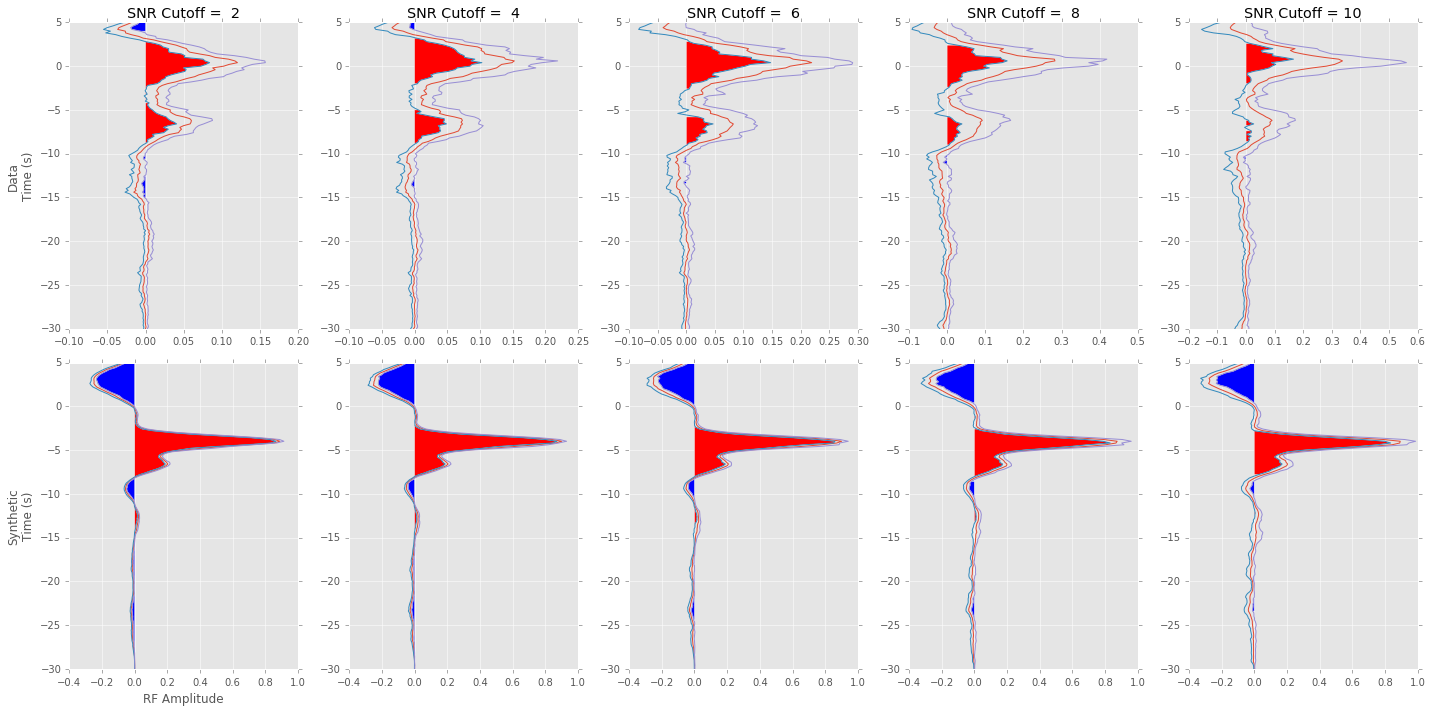

In [9]:
from numpy import nanmean, nanmedian, nanstd
from numpy.random import choice

#times, RF = ETMTM(P,D,TB,NT,dt, tag='data', nalphas=20, Poverlap=Poverlap, win_len=win_len)

#nrfs = len(cat2)
#nrfs = 329

minsnrs = arange(2, 12, 2)

#rbin_sn = rbin_s.copy() + randn(rbin_s.shape[0],rbin_s.shape[1],rbin_s.shape[2])*0.05

for iplt, minsnr in enumerate(minsnrs):
    for irow, rbin0 in enumerate([rbin, rbin_s]):
        
        snr_sample = arange(len(cat2))[mbin2[0,:]>minsnr]
        
        nrfs = len(snr_sample)
        
        rbin1=rbin0[0,snr_sample,:]
        
        nboot = 500

        bbin = zeros(nboot*len(RF)).reshape(nboot, len(RF))

        for iboot in range(nboot):
            random_sample = choice(range(nrfs), nrfs, replace=True)
            bbin[iboot,:] = nanmedian(rbin1[random_sample,:len(RF)],axis=0)

        plt.figure(1,figsize=(20,10))
        
        if irow == 0:
            plt.subplot(2,len(minsnrs),iplt+1)
        else:
            plt.subplot(2,len(minsnrs),iplt+1+len(minsnrs))

        plt.plot(nanmean(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0), times)

        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0),where = nanmedian(bbin, axis=0)-2*nanstd(bbin, axis=0)>0.0,facecolor='r')
        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0),where = nanmedian(bbin, axis=0)+2*nanstd(bbin, axis=0)<0.0,facecolor='b')
        #plt.plot(P)
        plt.ylim(-30,5)
        if irow == 0:
            plt.title('SNR Cutoff = %2d' % (minsnr) )

plt.subplot(2,len(minsnrs),1)
plt.ylabel('Data\nTime (s)')
plt.subplot(2,len(minsnrs),1+len(minsnrs))
plt.ylabel('Synthetic\nTime (s)')
plt.xlabel('RF Amplitude')

#plt.ylabel('Time (s)')
#plt.xlabel('RF Amplitude')
    
plt.tight_layout()
plt.savefig('RSSD_SNR.eps')

(array([ 742.,   87.,   41.,   17.,    6.,    8.,    4.,    3.,   19.,   20.]),
 array([  12.  ,   76.37,  140.74,  205.11,  269.48,  333.85,  398.22,
         462.59,  526.96,  591.33,  655.7 ]),
 <a list of 10 Patch objects>)

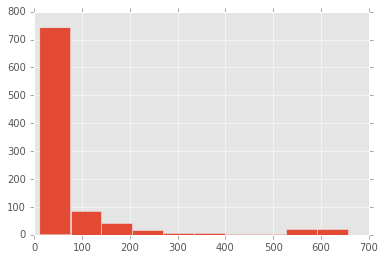

In [12]:
tmp=[]
for ievt, evt in enumerate(cat2):
    elat=evt.preferred_origin().latitude
    elon=evt.preferred_origin().longitude
    edep=evt.preferred_origin().depth/1000.0
    delm, az, baz = gps2dist_azimuth(elat, elon, slat, slon)
    deldeg = delm/1000./111.11
    tmp.append(edep)
    
plt.hist(tmp)

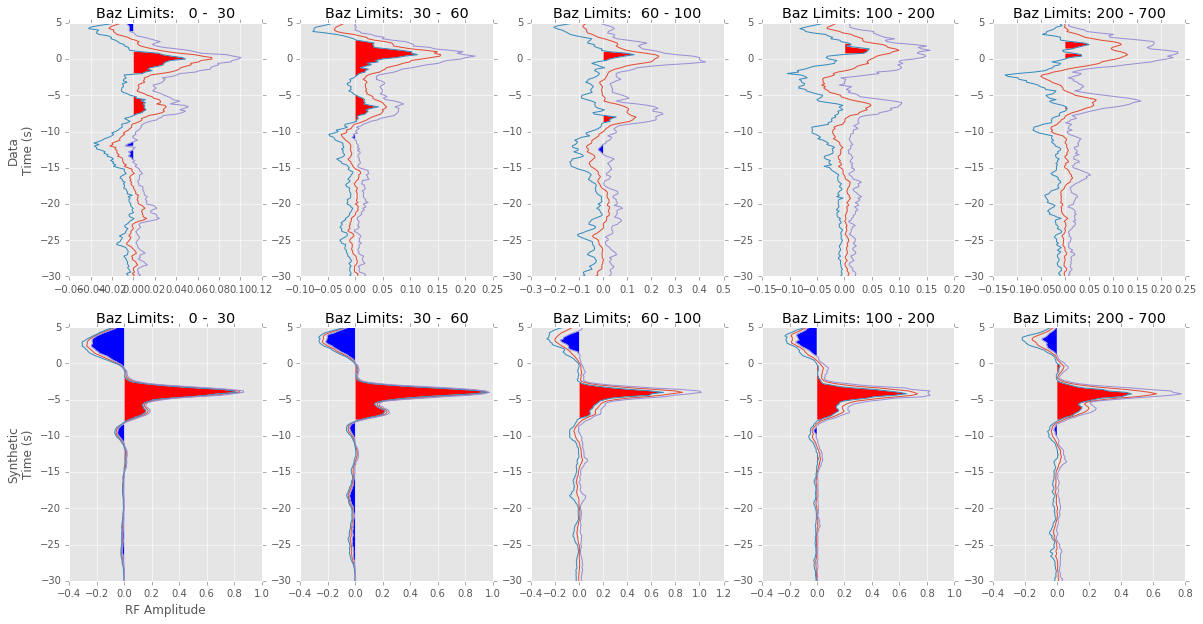

In [15]:
from numpy import nanmean, nanmedian, nanstd, array, shape
from numpy.random import choice

#times, RF = IDRF(P,D,dt)


depthranges = [(0,30),(30,60),(60,100),(100,200),(200,700)]

iplt = 4

for iplt, depthrange in enumerate(depthranges):
    for irow, rbin0 in enumerate([rbin, rbin_s]):
        
        dmin, dmax = depthrange[0], depthrange[1]

        slic = array(array(tmp) > dmin) & array(array(tmp) < dmax)

        #print(dmin, dmax, len(slic))

        nboot = 100

        bbin = zeros(nboot*len(RF)).reshape(nboot, len(RF))

        rbin2 = rbin0[0,slic,:len(RF)]
        nrf,_ = shape(rbin2)

        for iboot in range(nboot):

            random_sample = choice(range(nrf), nrf, replace=True)

            #print(nrf, len(random_sample))

            bbin[iboot,:] = nanmedian(rbin2[random_sample,:],axis=0)

        plt.figure(1,figsize=(20,10))
        
        if irow == 0:
            plt.subplot(2,len(depthranges),iplt+1)
        else:
            plt.subplot(2,len(depthranges),iplt+1+len(depthranges))

        plt.plot(nanmean(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0), times)
        plt.plot(nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0), times)

        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0),where = nanmean(bbin, axis=0)-2*nanstd(bbin, axis=0)>0.0,facecolor='r')
        plt.fill_betweenx(times,0,nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0),where = nanmean(bbin, axis=0)+2*nanstd(bbin, axis=0)<0.0,facecolor='b')
        #plt.plot(P)
        plt.ylim(-30,5)
        #plt.xlim(-0.3,0.3)
        plt.title('Baz Limits: %3d - %3d' % (dmin, dmax))

plt.subplot(2,len(depthranges),1)
plt.ylabel('Data\nTime (s)')
        
plt.subplot(2,len(depthranges),1+len(depthranges))
plt.ylabel('Synthetic\nTime (s)')
plt.xlabel('RF Amplitude')
    
#plt.tight_layout()
plt.savefig('RSSD_baz_limted.eps')